# Neural State Space Models in NeuroMANCER  


This tutorial demonstrates the use of [Neural State Space Models](https://ieeexplore.ieee.org/abstract/document/9482930) (NSSMs) for system identificaiton of dynamical systems with exogenous inputs. 
NSSMs are an extension of disctete-time linear [State Space Models](https://en.wikipedia.org/wiki/State-space_representation) (SSM) that have been traditionally used in control engineering for decades. Linear SSMs have the form $x_{k+1} = A x_k + B u_k$.  In NSSMs the linear maps $A$, $B$ are replaced by deep neural networks.


## System Identification Problem Setup

<img src="../figs/NSSM.PNG" width="500">  


Starting from a given initial condition  $x_{0}$, the next state of the system  $x_{k+1}$
is obtained by feeding the current state $x_{k}$ and current input $u_{k}$  into the NSSM defined by neural nets $A$ and $B$. In system identification, the loss $\mathcal{L}$ is evaluated by comparing the  trajectory generated by the model with the training trajectory. The process can be repeated for multiple trajectories to improve the generalization of the model.


### References

[1] [D. Masti and A. Bemporad, "Learning Nonlinear State-Space Models Using Deep Autoencoders," 2018 IEEE Conference on Decision and Control (CDC), Miami, FL, USA, 2018](https://ieeexplore.ieee.org/document/8619475)  
[2] [Daniel Gedon, Niklas Wahlström, Thomas B. Schön, Lennart Ljung,
Deep State Space Models for Nonlinear System Identification, IFAC-PapersOnLine, Volume 54, Issue 7, 2021](https://www.sciencedirect.com/science/article/pii/S2405896321011800)  
[3] [E. Skomski, S. Vasisht, C. Wight, A. Tuor, J. Drgoňa and D. Vrabie, "Constrained Block Nonlinear Neural Dynamical Models," 2021 American Control Conference (ACC), New Orleans, LA, USA, 2021](https://ieeexplore.ieee.org/abstract/document/9482930)  
[4] [Jesús M. Zamarreño, Pastora Vega,
State space neural network. Properties and application,
Neural Networks,
Volume 11, Issue 6,
1998](https://www.sciencedirect.com/science/article/pii/S0893608098000744)  
[5] [Christian Legaard, Thomas Schranz, Gerald Schweiger, Ján Drgoňa, Basak Falay, Cláudio Gomes, Alexandros Iosifidis, Mahdi Abkar, and Peter Larsen. 2023. Constructing Neural Network Based Models for Simulating Dynamical Systems. ACM Comput. Surv. 55, 11, Article 236 (November 2023), 34 pages.](https://dl.acm.org/doi/10.1145/3567591)



## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

In [10]:
import torch
import torch.nn as nn
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

torch.manual_seed(0)

## Generate trajectories from ODE system 

In this example we don't assume any prior knowledge on the system dynamics. We will only have access to limited measurements of the system states $x$ of an unknown [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation) (ODE).

Select the system_name from the available list of [nonautonomous ODE systems](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/psl/nonautonomous.py):
- TwoTank
- CSTR
- SwingEquation

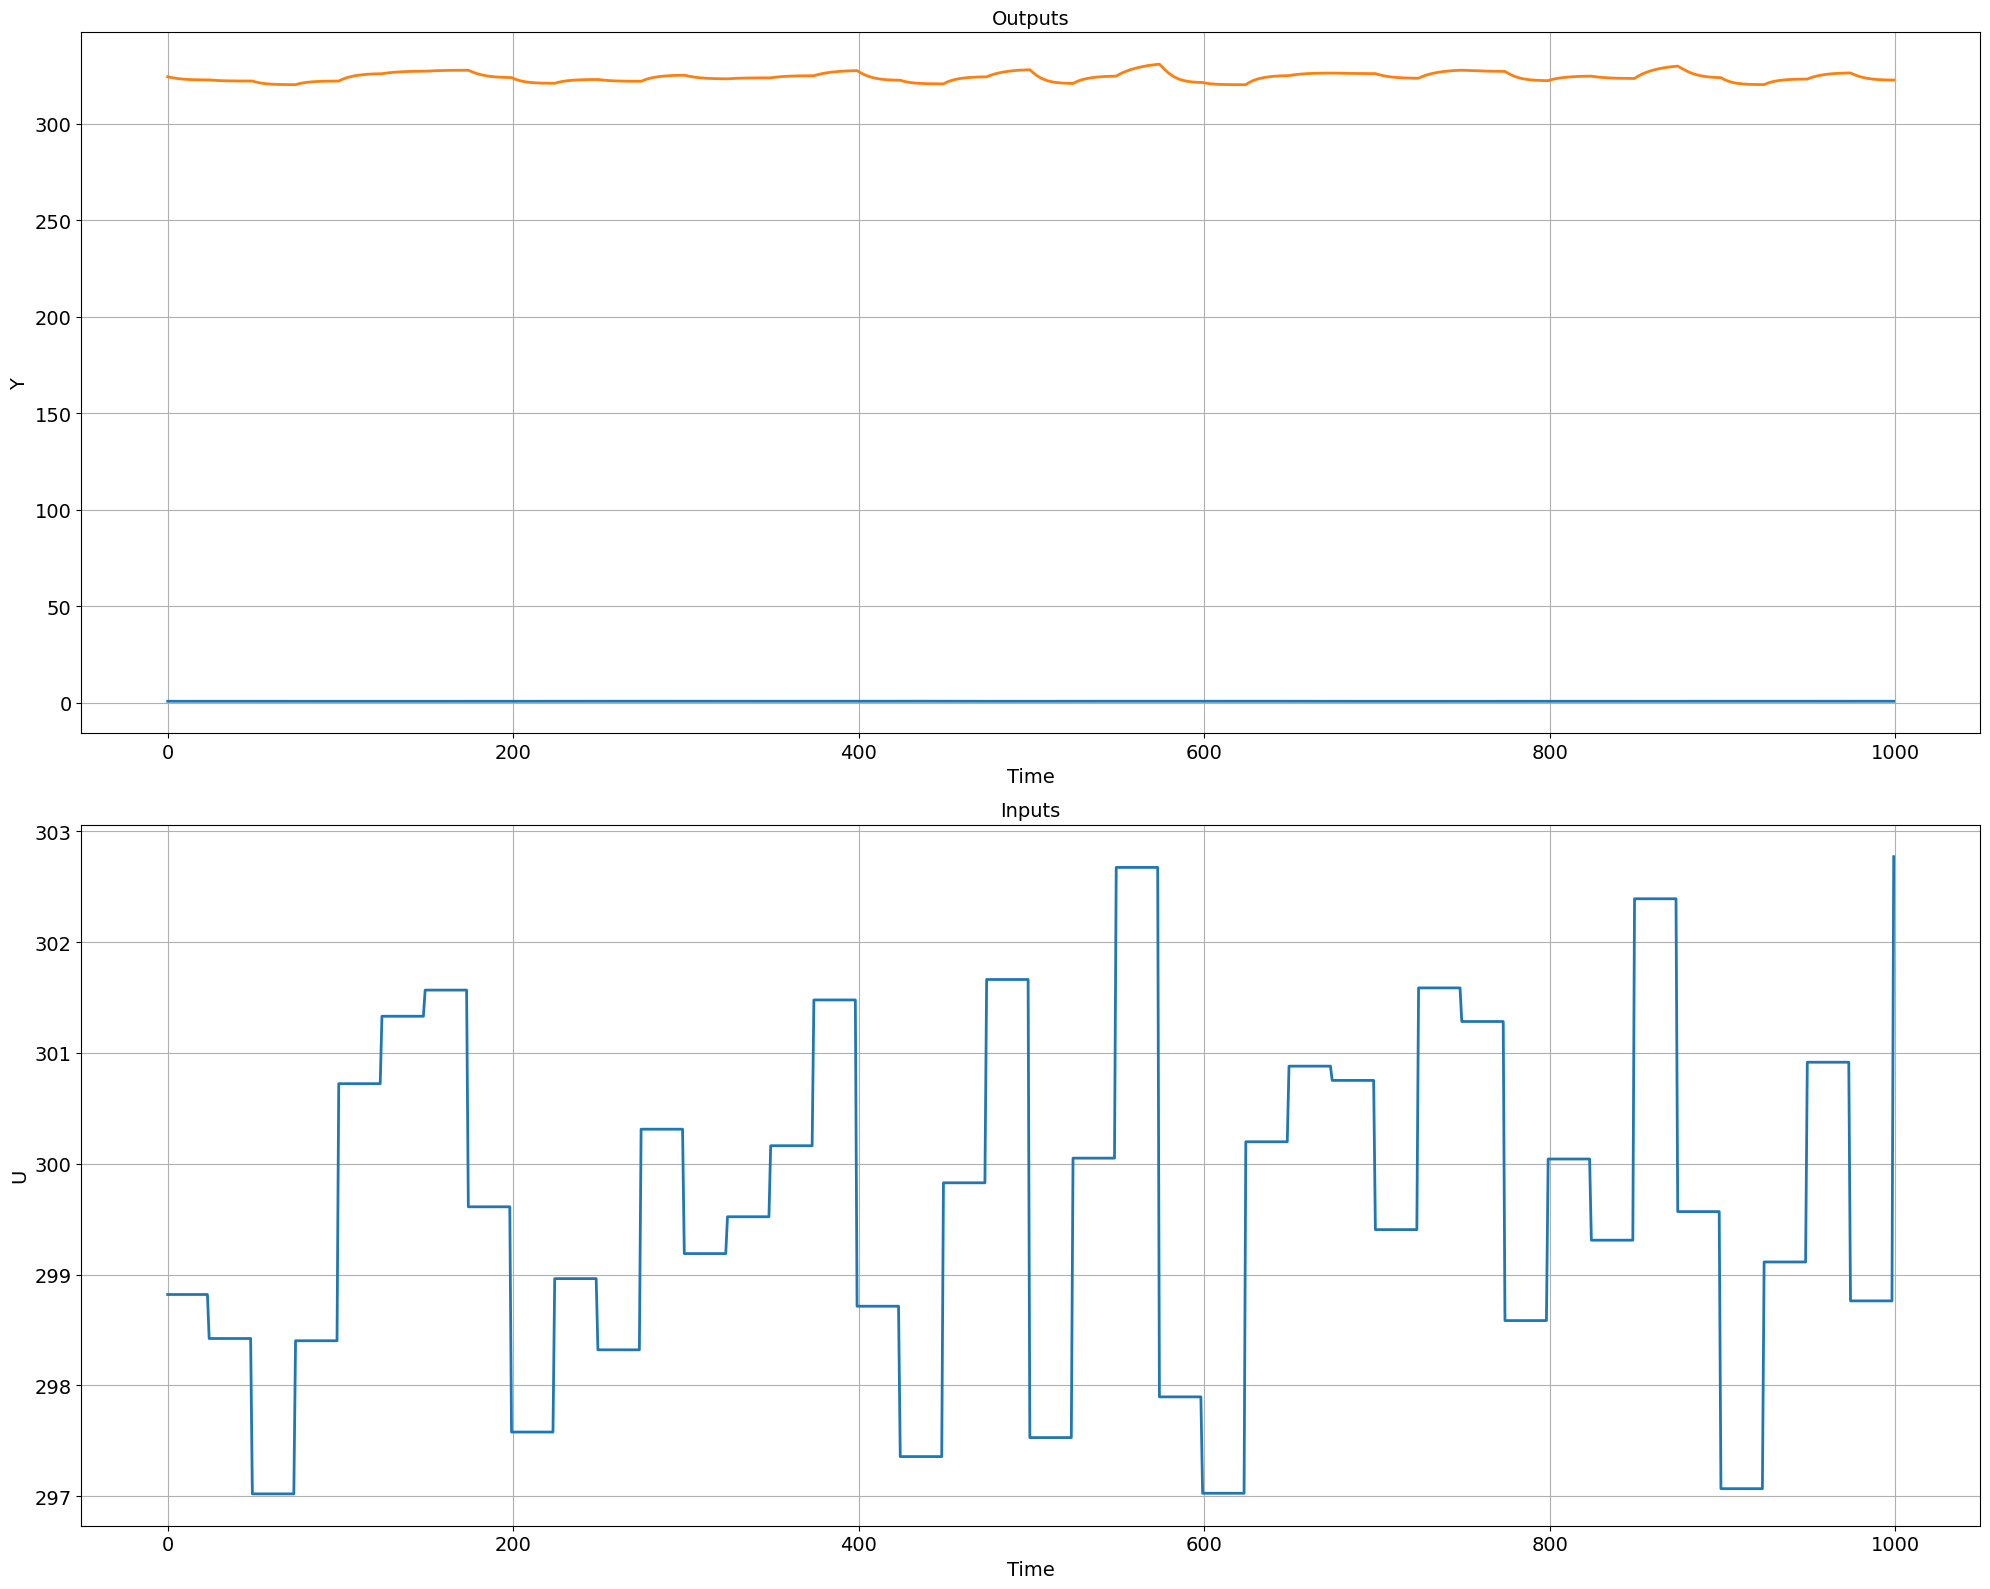

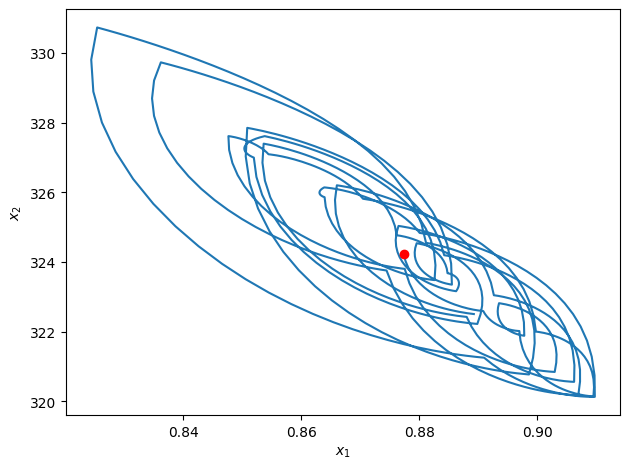

In [11]:
# %%  ground truth system
system_name = 'CSTR'
system = psl.systems[system_name]
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
nu = modelSystem.nu
raw = modelSystem.simulate(nsim=1000, ts=ts)
plot.pltOL(Y=raw['Y'], U=raw['U'])
plot.pltPhase(X=raw['Y'])

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics in the form of input-state tuples: 
$$D = \big[(u^i_0, \hat{x}^i_0), ..., (u^i_N, \hat{x}^i_{N}) \big], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.
Variables $x_k$ represent system states, and $u_k$ are exogenous inputs at time $k$.


In [12]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    # for systems with out of scale variables it is important to normalize the data before training
    mean_x = modelSystem.stats['X']['mean']
    std_x = modelSystem.stats['X']['std']
    mean_u = modelSystem.stats['U']['mean']
    std_u = modelSystem.stats['U']['std']
    def normalize(x, mean, std):
        return (x - mean) / std

    trainX = normalize(train_sim['X'][:length], mean_x, std_x)
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = normalize(train_sim['U'][:length], mean_u, std_u)
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = normalize(dev_sim['X'][:length], mean_x, std_x)
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = normalize(dev_sim['U'][:length], mean_u, std_u)
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = normalize(test_sim['X'][:length], mean_x, std_x)
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = normalize(test_sim['U'][:length], mean_u, std_u)
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :],
                 'U': testU}

    return train_loader, dev_loader, test_data


In [13]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 10   # number of prediction horizon steps in the loss function
bs = 100      # minibatching batch size
train_loader, dev_loader, test_data = get_data(modelSystem, nsim, nsteps, ts, bs)

## NSSM system model in Neuromancer

Here we construct a state space model  $x_{k+1} = A_{\theta}(x_k) + B_{\theta}(u_k) $ with $A$ and $B$ parametrized by neural networks with trainable parameters $\theta$.

In [14]:
# define the state space model as neural architecture
class SSM(nn.Module):
    """
    Baseline class for (neural) state space model (SSM)
    Implements discrete-time dynamical system:
        x_k+1 = fx(x_k) + fu(u_k) 
    with variables:
        x_k - states
        u_k - control inputs
    """
    def __init__(self, fx, fu, nx, nu):
        super().__init__()
        self.fx, self.fu = fx, fu
        self.nx, self.nu = nx, nu
        self.in_features, self.out_features = nx+nu, nx

    def forward(self, x, u, d=None):
        """
        :param x: (torch.Tensor, shape=[batchsize, nx])
        :param u: (torch.Tensor, shape=[batchsize, nu])
        :return: (torch.Tensor, shape=[batchsize, outsize])
        """
        # state space model
        x = self.fx(x) + self.fu(u)
        return x

In [15]:
# instantiate neural nets
A = blocks.MLP(nx, nx, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[40, 40])
B = blocks.MLP(nu, nx, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ReLU,
                hsizes=[40, 40])
# construct NSSM model in Neuromancer
ssm = SSM(A, B, nx, nu)

For training we need to obtain accurate reverse-mode gradients by unrolling the operations of the NSSM and using the [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time) (BPTT) algorithm. Numner of steps (nsteps) to rollout the NSSM model can be specified in the symbolic System model in Neuromancer.

In [16]:
# create symbolic system model in Neuromancer
model = Node(ssm, ['xn', 'U'], ['xn'], name='NODE')
dynamics_model = System([model], name='system', nsteps=nsteps)

In [17]:
# visualize the system
# dynamics_model.show()

## Define system identification loss function terms

Here we define loss function terms to fit the ODE parameters from given time-series data.

**Tracking loss:**  
$$\ell_x = Q_N||x^i_k - \hat{x}^i_k||_2^2$$ 
**One-step loss:**  
$$\ell_x = Q_1||x^i_1 - \hat{x}^i_1||_2^2$$ 

In [18]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]

# trajectory tracking loss
reference_loss = 5.*(xhat == x)^2
reference_loss.name = "ref_loss"

# one step tracking loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

## Construct System ID learning problem

Given the training dataset $D$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big(Q_1||x^i_1 - \hat{x}^i_1||_2^2 + \sum_{k=1}^{N}  Q_N||x^i_k - \hat{x}^i_k||_2^2   \Big) \\
&\text{subject to}    && x^i_{k+1} = A_{\theta}(x_k^i) + B_{\theta}(u_k^i) \\
\end{align}
$$  

In [19]:
# aggregate list of objective terms and constraints
objectives = [reference_loss, onestep_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

In [20]:
# plot computational graph
# problem.show()

## Solve the problem

We fit the unknown NSSM parameters $\theta$ using stochastic gradient descent.

In [21]:
optimizer = torch.optim.Adam(problem.parameters(),
                             lr=0.003)
# trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=100,
    warmup=100,
    epochs=1000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)

In [22]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0  train_loss: 5.127842903137207
epoch: 1  train_loss: 4.462972164154053
epoch: 2  train_loss: 3.931211471557617
epoch: 3  train_loss: 3.448476552963257
epoch: 4  train_loss: 2.935964345932007
epoch: 5  train_loss: 2.4600934982299805
epoch: 6  train_loss: 2.082817316055298
epoch: 7  train_loss: 1.8034785985946655
epoch: 8  train_loss: 1.732630968093872
epoch: 9  train_loss: 1.7317094802856445
epoch: 10  train_loss: 1.6387038230895996
epoch: 11  train_loss: 1.3933247327804565
epoch: 12  train_loss: 1.2000491619110107
epoch: 13  train_loss: 1.0618818998336792
epoch: 14  train_loss: 0.8826831579208374
epoch: 15  train_loss: 0.6778758764266968
epoch: 16  train_loss: 0.559308648109436
epoch: 17  train_loss: 0.4252130389213562
epoch: 18  train_loss: 0.3839513063430786
epoch: 19  train_loss: 0.41940975189208984
epoch: 20  train_loss: 0.336641401052475
epoch: 21  train_loss: 0.22940349578857422
epoch: 22  train_loss: 0.2280922830104828
epoch: 23  train_loss: 0.22279506921768188
epoch: 2

epoch: 189  train_loss: 0.0012203860096633434
epoch: 190  train_loss: 0.0014617404667660594
epoch: 191  train_loss: 0.000987028470262885
epoch: 192  train_loss: 0.0011062499834224582
epoch: 193  train_loss: 0.00114101090002805
epoch: 194  train_loss: 0.0011176865082234144
epoch: 195  train_loss: 0.002021313877776265
epoch: 196  train_loss: 0.0017582131549715996
epoch: 197  train_loss: 0.0011978630209341645
epoch: 198  train_loss: 0.0008767066756263375
epoch: 199  train_loss: 0.0008842551615089178
epoch: 200  train_loss: 0.0010819068411365151
epoch: 201  train_loss: 0.0013058206532150507
epoch: 202  train_loss: 0.0011118557304143906
epoch: 203  train_loss: 0.0011968499748036265
epoch: 204  train_loss: 0.0016272665234282613
epoch: 205  train_loss: 0.0010009940015152097
epoch: 206  train_loss: 0.001328946091234684
epoch: 207  train_loss: 0.0017025887500494719
epoch: 208  train_loss: 0.0009907024214044213
epoch: 209  train_loss: 0.0009702816605567932
epoch: 210  train_loss: 0.0008905533468

epoch: 377  train_loss: 0.021515393629670143
epoch: 378  train_loss: 0.008126877248287201
epoch: 379  train_loss: 0.021022234112024307
epoch: 380  train_loss: 0.005374722182750702
epoch: 381  train_loss: 0.013119482435286045
epoch: 382  train_loss: 0.006194699555635452
epoch: 383  train_loss: 0.007174389902502298
epoch: 384  train_loss: 0.018913188949227333
epoch: 385  train_loss: 0.008348209783434868
epoch: 386  train_loss: 0.02144688367843628
epoch: 387  train_loss: 0.015261673368513584
epoch: 388  train_loss: 0.010012930259108543
epoch: 389  train_loss: 0.01892988011240959
epoch: 390  train_loss: 0.008870238438248634
epoch: 391  train_loss: 0.0056104157119989395
epoch: 392  train_loss: 0.00913301669061184
epoch: 393  train_loss: 0.007182858418673277
epoch: 394  train_loss: 0.004887458402663469
epoch: 395  train_loss: 0.008380884304642677
epoch: 396  train_loss: 0.006358750630170107
epoch: 397  train_loss: 0.0034760022535920143
epoch: 398  train_loss: 0.0036505679599940777
epoch: 399

epoch: 561  train_loss: 0.0005997779662720859
epoch: 562  train_loss: 0.0004157016228418797
epoch: 563  train_loss: 0.0005923394928686321
epoch: 564  train_loss: 0.0003603961376938969
epoch: 565  train_loss: 0.000374924682546407
epoch: 566  train_loss: 0.00040111213456839323
epoch: 567  train_loss: 0.00031555088935419917
epoch: 568  train_loss: 0.000787131953984499
epoch: 569  train_loss: 0.00066996063105762
epoch: 570  train_loss: 0.00043072697008028626
epoch: 571  train_loss: 0.00043099833419546485
epoch: 572  train_loss: 0.000747940968722105
epoch: 573  train_loss: 0.0004596914513967931
epoch: 574  train_loss: 0.0004296471015550196
epoch: 575  train_loss: 0.0005920915864408016
epoch: 576  train_loss: 0.001634111162275076
epoch: 577  train_loss: 0.00179721147287637
epoch: 578  train_loss: 0.0005702359485439956
epoch: 579  train_loss: 0.002132676774635911
epoch: 580  train_loss: 0.002629549242556095
epoch: 581  train_loss: 0.001176246558316052
epoch: 582  train_loss: 0.000572754302993

<All keys matched successfully>

## Parameter estimation results

In [23]:
# update the rollout length based on the test data
dynamics_model.nsteps = test_data['X'].shape[1]

In [24]:
# Test set results
test_outputs = dynamics_model(test_data)

pred_traj = test_outputs['xn'][:, :-1, :].detach().numpy().reshape(-1, nx)
true_traj = test_data['X'].detach().numpy().reshape(-1, nx)
input_traj = test_data['U'].detach().numpy().reshape(-1, nu)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

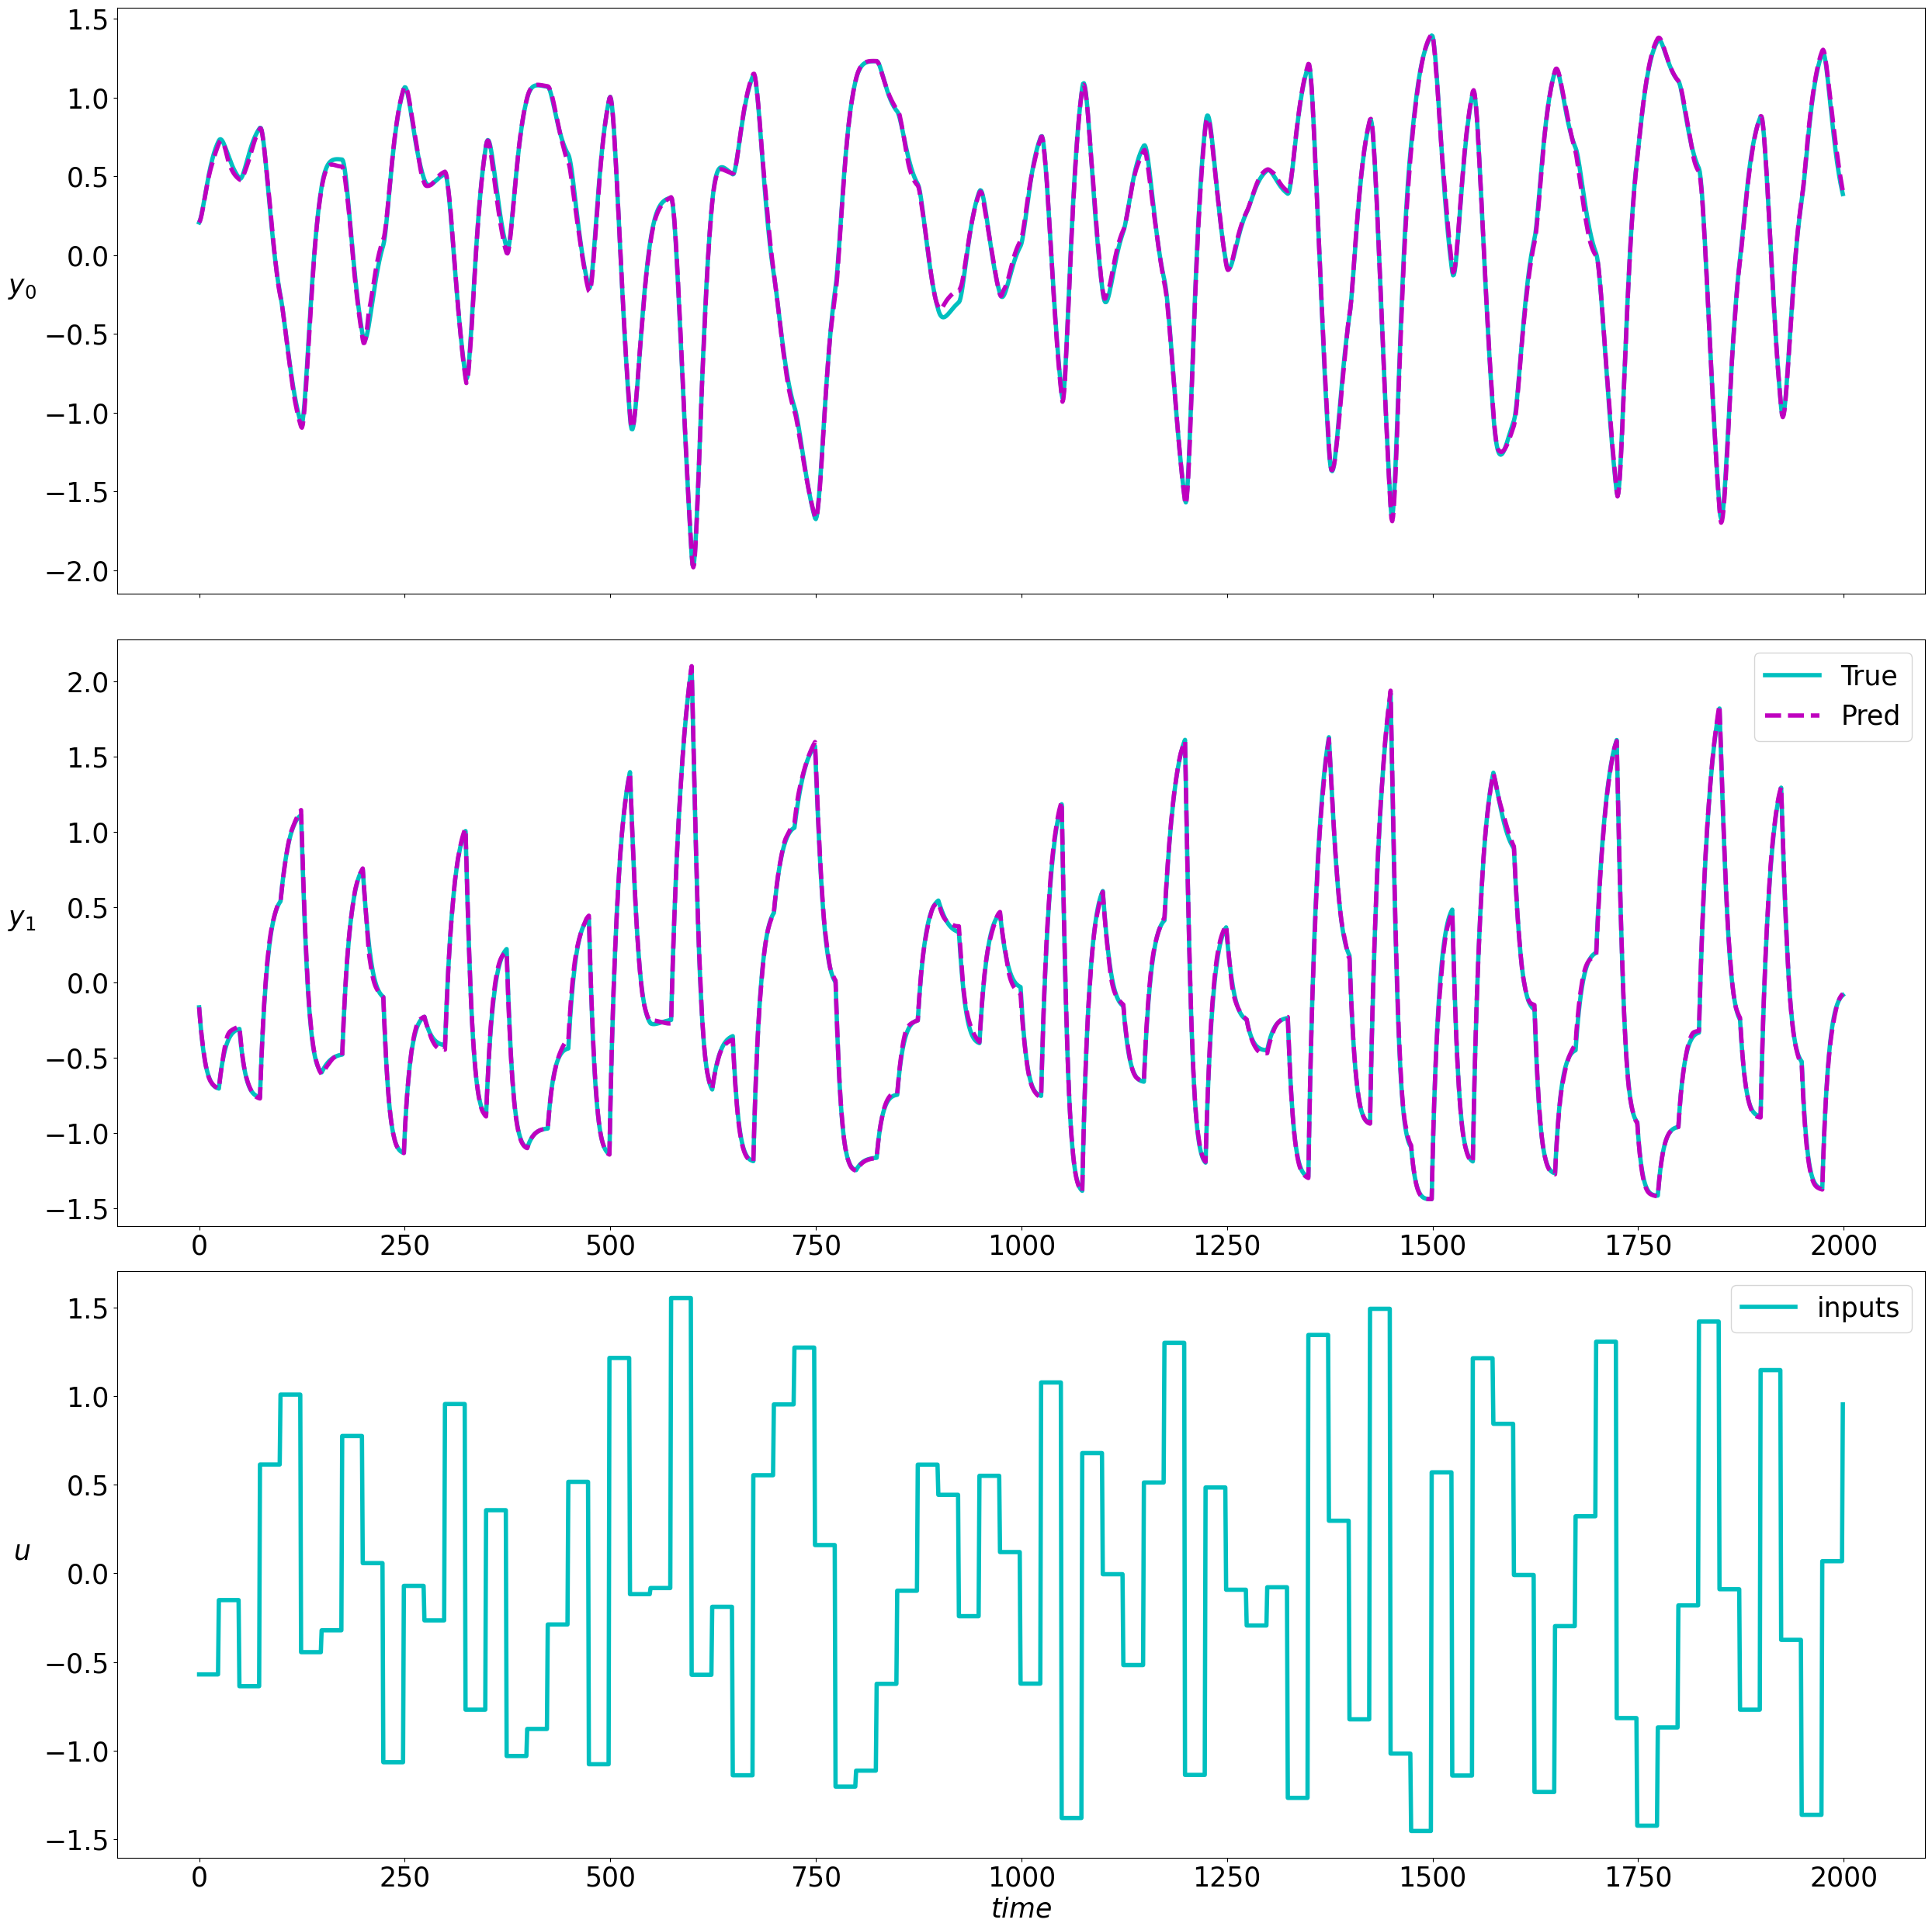

In [25]:
# plot rollout
figsize = 25
fig, ax = plt.subplots(nx + nu, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
ax[-1].plot(input_traj, 'c', linewidth=4.0, label='inputs')
ax[-1].legend(fontsize=figsize)
ax[-1].set_xlabel('$time$', fontsize=figsize)
ax[-1].set_ylabel('$u$', rotation=0, labelpad=20, fontsize=figsize)
ax[-1].tick_params(labelbottom=True, labelsize=figsize)
plt.tight_layout()